# Introduction: New York City Taxi Fare Prediction 

The New York City Taxi Fare Prediction dataset is a challenge hosted by Kaggle in partnership with Google Cloud and Coursera. 
This dataset uses a selection from the massive New York City (NYC) Taxi and Limousine Commission (TLC) Yellow Cab dataset that is also publicly available on Big Query.

The goal of this project is to predict the fare amount of a taxi ride given the input features like pickup_datetime, pickup/dropoff latitude, pickup/dropoff longitude and number of passengers. This is a Supervised regression machine learning task. 

Competition Link -
https://www.kaggle.com/c/new-york-city-taxi-fare-prediction#description

This is a huge dataset consisting of 55M rows in the training set and 10k rows in the test set. The project has been divided into different phases and each phase covers a substantial amount of work.

For **Phase2**, we have experimented with 1 million rows and made use of the entire 55M rows of training dataset for Model Evaluation. Tasks are prefixed with **Phase2** label to identify the tasks done in phase2. The following tasks are performed for this phase:
- Remove the geo locations present in water.
- Created new features around distance using Minkowski method using Euclidean and Manhattan formula.
- Performed additional EDA around the distance features and the timestamp related features.
- Removed rows with haversine distances less than 0.05 miles.
- Created features by calculating airport distances and distance to center of New York City.
- Created class for Feature Engineering and Data cleanup.
- Experimented with new algorithms like XGBoost, PolynomialFeatures+Ridge, SGDRegressor.
- Performed hyperparameter tuning using RandomizedCV along with GridSearchCV.
- Wrapped all the preparation and predictor steps in a pipeline.

For **Phase1** out of 55M rows, we downsampled and utilized just 1 million rows. This phase covers the following tasks:
- Dropped the missing rows using dropna
- Removed the outliers in all the columns using percentile approach
- Created distance feature from the latitude/longitude columns
- Created features from pickup_datetime column
- Created class for Data cleanup and removal of outliers
- Created class for feature extraction
- Experimented with Linear Regression and Random forest algorithms for model evaluation
- Performed GridSearch and statistical significance tests
- Wrapped all the preparation and predictor steps in a pipeline.
- Submitted the best model to Kaggle and loaded the results in the results table.

# Notebook Preparation

In [1]:
import dill

import matplotlib.pyplot as plt
import numpy as np
import os
import feather
import pandas as pd
import sys
import seaborn as sns
import warnings
warnings.simplefilter('ignore')

from collections import Counter
from scipy import sparse, stats
from scipy.stats import randint
from sklearn import preprocessing as prep
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso, LinearRegression, Ridge, SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Imputer, StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
from sklearn.utils import check_array
from xgboost import XGBRegressor
from time import time

%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, x_in, y=None):
        return self
    def transform(self, x_in):
        return x_in[self.attribute_names].values

In [3]:
# Set up reporting
import pandas as pd
results = pd.DataFrame(columns=["ExpID", "Train RMSE", "Test RMSE", "p-value","t-stat", "Train Time(s)", "Test Time(s)", "Experiment description"])

# Load Data

## Training Data

In [6]:
data = pd.read_csv('data/train.csv',parse_dates=["pickup_datetime"])

In [7]:
import feather
path = 'data/data.feather'
feather.write_dataframe(data, path)

In [8]:
data.shape

(55423856, 8)

In [9]:
df = feather.read_dataframe('data/data.feather')

In [10]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,5.542386e+07,5.542386e+07,5.542386e+07,5.542348e+07,5.542348e+07,5.542386e+07
mean,1.134505e+01,-7.250968e+01,3.991979e+01,-7.251121e+01,3.992068e+01,1.685380e+00
std,2.071083e+01,1.284888e+01,9.642353e+00,1.278220e+01,9.633346e+00,1.327664e+00
min,-3.000000e+02,-3.442060e+03,-3.492264e+03,-3.442025e+03,-3.547887e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073493e+01,-7.399140e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398180e+01,4.075265e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396708e+01,4.076713e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,9.396336e+04,3.457626e+03,3.408790e+03,3.457622e+03,3.537133e+03,2.080000e+02


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55423856 entries, 0 to 55423855
Data columns (total 8 columns):
key                  object
fare_amount          float64
pickup_datetime      datetime64[ns]
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count      int64
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 3.3+ GB


In [12]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


In [13]:
data.isnull().sum()

key                    0
fare_amount            0
pickup_datetime        0
pickup_longitude       0
pickup_latitude        0
dropoff_longitude    376
dropoff_latitude     376
passenger_count        0
dtype: int64

In [14]:
sampletrain = data.sample(10000)
sampletrain50k = data.sample(50000)
sampletrain100k = data.sample(100000)
sampletrain500k = data.sample(500000)
sampletrain1m = data.sample(1000000)

In [15]:
feather.write_dataframe(sampletrain, 'data/sampletrain.feather')
feather.write_dataframe(sampletrain50k, 'data/sampletrain50k.feather')
feather.write_dataframe(sampletrain100k, 'data/sampletrain100k.feather')
feather.write_dataframe(sampletrain500k, 'data/sampletrain500k.feather')
feather.write_dataframe(sampletrain1m, 'data/sampletrain1m.feather')

In [16]:
sampletrain50k.to_csv('data/sampletrain50k.csv')
sampletrain100k.to_csv('data/sampletrain100k.csv')
sampletrain500k.to_csv('data/sampletrain500k.csv')
sampletrain1m.to_csv('data/sampletrain1m.csv')

## Test Data

In [4]:
test = pd.read_csv('data/test.csv',parse_dates=["pickup_datetime"])

In [18]:
test.shape

(9914, 7)

In [19]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9914 entries, 0 to 9913
Data columns (total 7 columns):
key                  9914 non-null object
pickup_datetime      9914 non-null datetime64[ns]
pickup_longitude     9914 non-null float64
pickup_latitude      9914 non-null float64
dropoff_longitude    9914 non-null float64
dropoff_latitude     9914 non-null float64
passenger_count      9914 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 542.2+ KB


In [20]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [21]:
test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1


# Exploratory Data Analysis and Preprocessing

## Downsample the data so that we can experiment more easily

Let's downsample the data by taking a random sample of 1million records from the training sets.

In [52]:
sampletrain = pd.read_csv('data/sampletrain1m.csv', parse_dates=["pickup_datetime"])

In [53]:
sampletrain.shape

(1000000, 9)

In [54]:
sampletrain.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

Remove the unnecessary columns from the dataset

In [55]:
sampletrain = sampletrain[['pickup_datetime', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'fare_amount']]

In [56]:
sampletrain.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
0,2014-05-16 09:28:00,-73.938528,40.805310,-73.870817,40.773962,1,24.33
1,2011-10-14 15:21:55,0.000000,0.000000,0.000000,0.000000,1,12.90
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.50
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.50
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.30


## Data Quality Check

In [57]:
sampletrain.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,1000000.000000,1000000.000000,999996.000000,999996.000000,1000000.000000,1000000.000000
mean,-72.494666,39.919985,-72.498725,39.912088,1.686277,11.336244
std,12.200565,11.563661,13.226220,11.549880,1.325450,9.721400
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,-60.000000
25%,-73.992062,40.734955,-73.991379,40.734065,1.000000,6.000000
50%,-73.981814,40.752643,-73.980141,40.753183,1.000000,8.500000
75%,-73.967095,40.767075,-73.963622,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


Looking at the statistics above, we see that there are outliers in all the columns. Fare_amount cannot be negative, and passenger_count cannot be 208. The latitude and longitude columns are also out of range. The valid latitude values should be between -90/+90 and valid longitude values should be between -180/+180. We need a way to handle these outliers. 

In [58]:
sampletrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
pickup_datetime      1000000 non-null datetime64[ns]
pickup_longitude     1000000 non-null float64
pickup_latitude      1000000 non-null float64
dropoff_longitude    999996 non-null float64
dropoff_latitude     999996 non-null float64
passenger_count      1000000 non-null int64
fare_amount          1000000 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.4 MB


In [59]:
sampletrain.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

Out of 1 million records, we have 4 missing values. The best way would be to drop these missing values since we have enough data for our analysis. 

## Visualize the target column

Let's plot a histogram of the target column.

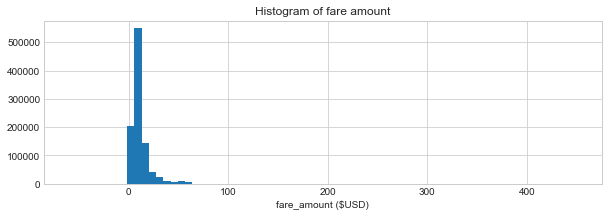

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
sampletrain.fare_amount.hist(bins=70, figsize=(10,3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram of fare amount');
plt.show()

In [61]:
# Looks like fare is negative - surely a noisy data, let's drop those rows
print('Original number of rows: %d' % len(sampletrain))
df = sampletrain[sampletrain.fare_amount>0]
print('No. of rows after removing negative fare amount: %d' % len(df))

Original number of rows: 1000000
No. of rows after removing negative fare amount: 999937


In [62]:
# Let's evaluate how many rows have fare greater than 100
df[df.fare_amount>100].describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,335.000000,335.000000,335.000000,335.000000,335.000000,335.000000
mean,-67.276302,37.103753,-66.426684,36.664408,1.385075,137.148866
std,21.131734,11.654829,22.360552,12.342200,0.857034,46.141356
min,-74.435527,0.000000,-74.535058,0.000000,1.000000,100.200000
25%,-73.988071,40.664254,-74.171242,40.690323,1.000000,109.790000
50%,-73.874480,40.750108,-73.963578,40.745679,1.000000,120.000000
75%,-73.783853,40.771797,-73.620004,40.900874,1.000000,150.000000
max,0.000000,41.304762,0.000000,41.304762,6.000000,450.000000


**Out of close to 1 million rows there are 335 rows where fare_amount is more than 100 dollars. To have better picture of fare distribution, let's plot histogram of those rows where fare is less than 100.**

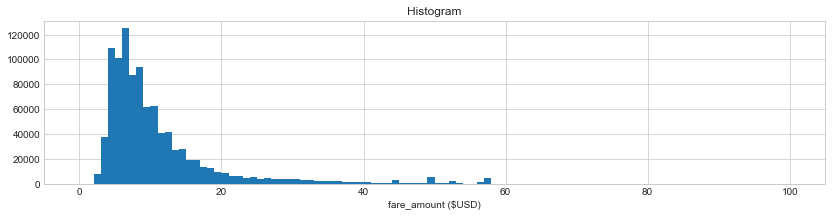

In [63]:
# let's take insight of the Y - Fare 
df[df.fare_amount<100].fare_amount.hist(bins=100, figsize=(14,3))
plt.xlabel('fare_amount ($USD)')
plt.title('Histogram');

## Deal with missing values

Here we have enormous amount of data, best approach to deal with missing data would be to drop rows where any column has a null or nan values. 

In [64]:
df.isnull().sum()

pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    4
dropoff_latitude     4
passenger_count      0
fare_amount          0
dtype: int64

In [65]:
print('Original number of rows: %d' % len(df))
df = df.dropna(how='any', axis='rows')
print('No. of rows after dropping missing values: %d' % len(df))

Original number of rows: 999937
No. of rows after dropping missing values: 999933


## Remove Outliers

In [66]:
# Lets review the stat after removal of NAN values
df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000,999933.000000
mean,-72.494863,39.920092,-72.498928,39.912199,1.686261,11.337401
std,12.200107,11.563771,13.225837,11.549967,1.325425,9.719923
min,-2053.689307,-3441.914335,-3003.016195,-3441.914335,0.000000,0.010000
25%,-73.992063,40.734956,-73.991379,40.734066,1.000000,6.000000
50%,-73.981814,40.752644,-73.980141,40.753183,1.000000,8.500000
75%,-73.967096,40.767075,-73.963623,40.768110,2.000000,12.500000
max,2526.488913,3285.747978,3225.513947,3322.091548,208.000000,450.000000


__Looking at the max/min of all the columns, looks like we have outliers on each column. Example, passenger count cannot be 208. To remove the outliers, we will adopt the percentile approach to see if we can filter data with valid range of values.__

__First let's take a look at middle 98 percentile of data.__

In [67]:
low = .01
high = .99
quant_df  = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.01        -74.014264         0.000000         -74.015237          0.000000   
0.99          0.000000        40.806813           0.000000         40.830765   

      passenger_count  fare_amount  
0.01              1.0          3.3  
0.99              6.0         52.5  


We still see outliers in the latitude and longitude columns. 

__So, let's now try for middle 96 percentile of data.__ 

In [68]:
low = .02
high = .98
quant_df  = df.quantile([low, high])
print(quant_df)

      pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0.02        -74.010257        40.566743         -74.011853         40.545672   
0.98        -73.137393        40.799663         -73.137393         40.810127   

      passenger_count  fare_amount  
0.02              1.0         3.50  
0.98              6.0        46.83  


As per http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml#GroupRideInformation, the minimum fare for a taxi ride cannot be less than $\$2.5$. The percentile approach gives us minimum fare as $\$3.5$.

In [69]:
print('Original number of rows: %d' % len(df))
data_prepared = df[(df.fare_amount>=df.fare_amount.quantile(low))
    & (df.fare_amount<=df.fare_amount.quantile(high))
     
    & (df.pickup_longitude >=df.pickup_longitude.quantile(low))
    & (df.pickup_longitude <=df.pickup_longitude.quantile(high))
    
    & (df.pickup_latitude  >=df.pickup_latitude.quantile(low))
    & (df.pickup_latitude  <=df.pickup_latitude.quantile(high))
       
    & (df.dropoff_longitude  >=df.dropoff_longitude.quantile(low))
    & (df.dropoff_longitude  <=df.dropoff_longitude.quantile(high))
       
    & (df.dropoff_latitude  >=df.dropoff_latitude.quantile(low))
    & (df.dropoff_latitude  <=df.dropoff_latitude.quantile(high))
      
    & (df.passenger_count  >=df.passenger_count.quantile(low))
    & (df.passenger_count  <=df.passenger_count.quantile(high))
       
       ]
print('Number of rows after removing outliers: %d' % len(data_prepared))

Original number of rows: 999933
Number of rows after removing outliers: 874468


__Data looks much cleaner now so let's apply this filtering.__

In [70]:
# Lets take a look on stat now
data_prepared.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000,874468.000000
mean,-73.976850,40.751310,-73.975418,40.750897,1.690947,10.195427
std,0.029143,0.023090,0.028767,0.026104,1.306218,6.740902
min,-74.010257,40.566809,-74.011853,40.546040,1.000000,3.500000
25%,-73.991890,40.738033,-73.991220,40.737152,1.000000,6.000000
50%,-73.982194,40.753590,-73.980738,40.753860,1.000000,8.100000
75%,-73.969698,40.766690,-73.966862,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Visualize the features 

### Plot a histogram

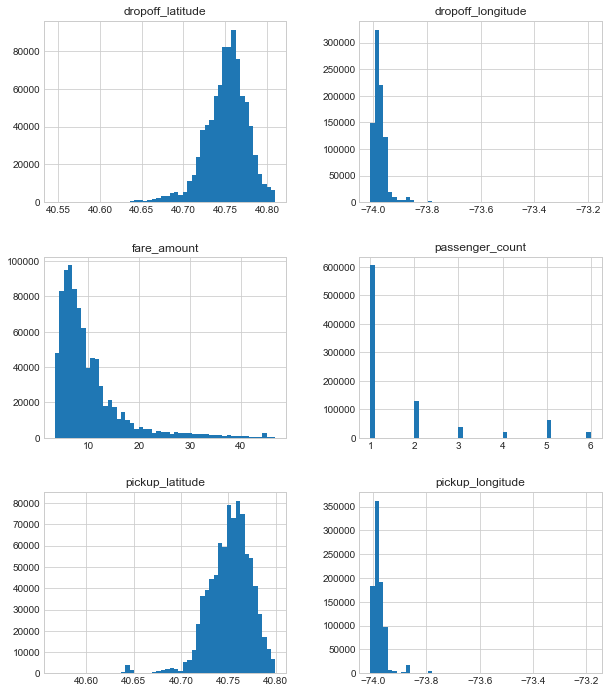

In [71]:
%matplotlib inline
import matplotlib.pyplot as plt
data_prepared.hist(bins=50, figsize=(10,12))
plt.show()

### Plot to see if passenger_count is related to target

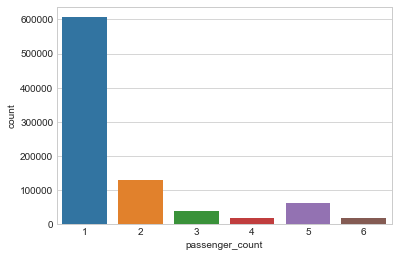

In [72]:
# Count plot on passenger count
sns.countplot(x="passenger_count", data=data_prepared)

In [73]:
passenger_grp = data_prepared.groupby('passenger_count')
passenger_grp['fare_amount'].agg(['mean', 'count'])

,mean,count
passenger_count,,
1,10.112107,606581
2,10.458585,129920
3,10.351840,38870
4,10.376284,18540
5,10.119960,61854
6,10.814877,18703


Plot to see if there is a correlation between the number of passengers and the fare amount.

Text(0.5,1,'Average fare by Passenger count')

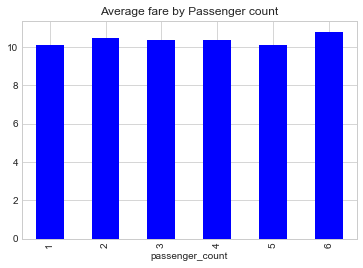

In [74]:
passenger_grp['fare_amount'].mean().plot.bar(color='b');
plt.title('Average fare by Passenger count')

As we can see, there is a small but noticeable difference between the number of passengers and the fare amount. 

### Plot the pick up and drop off locations on NYC Map

We have adopted some of the code for plotting of maps and visualizing the ECDF. Below are the references provided. 

**References:** <p>
- https://towardsdatascience.com/another-machine-learning-walk-through-and-a-challenge-8fae1e187a64
- https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration 

In [75]:
# Reference https://aiblog.nl/

# load image of NYC map
# We will use aiblog.nl web service to load the map 
nyc = (-74.5, -72.8, 40.5, 41.8)
nyc_map = plt.imread('download/nyc_-74.5_-72.8_40.5_41.8.png')

# Increasing zoom level to see map in a detailed way 
nyc_zoom = (-74.3, -73.7, 40.5, 40.9)
nyc_map_zoom = plt.imread('download/nyc_-74.3_-73.7_40.5_40.9.png')

In [76]:
def plot_on_map(df, BB, nyc_map, s=10, alpha=0.2):
    ''' 
    Function to plot the pickup and dropoff locations on the map.
    input: dataframe, coordinates of NYC, map of the NYC
    output: plots the training data on the map
    
    '''
    fig, axs = plt.subplots(1, 2, figsize=(16,10))
    axs[0].scatter(df.pickup_longitude, df.pickup_latitude, zorder=1, alpha=alpha, c='y', s=s)
    axs[0].set_xlim((BB[0], BB[1]))
    axs[0].set_ylim((BB[2], BB[3]))
    axs[0].set_title('Pickup locations')
    axs[0].imshow(nyc_map, zorder=0, extent=BB)

    axs[1].scatter(df.dropoff_longitude, df.dropoff_latitude, zorder=1, alpha=alpha, c='r', s=s)
    axs[1].set_xlim((BB[0], BB[1]))
    axs[1].set_ylim((BB[2], BB[3]))
    axs[1].set_title('Dropoff locations')
    axs[1].imshow(nyc_map, zorder=0, extent=BB)

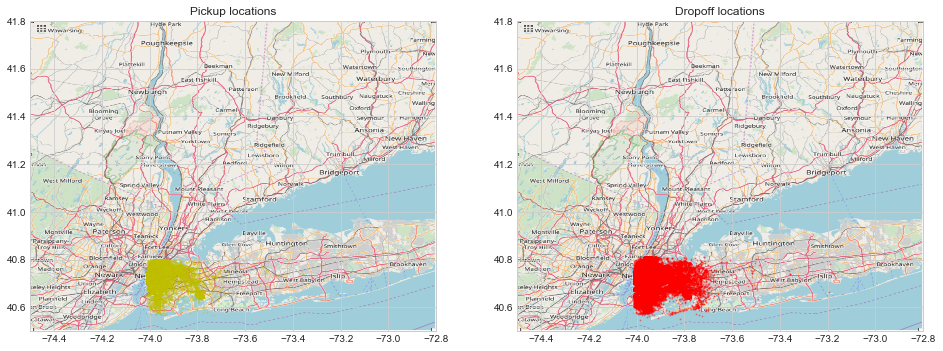

In [77]:
# plot training data on map
plot_on_map(data_prepared, nyc, nyc_map, s=1, alpha=0.3)

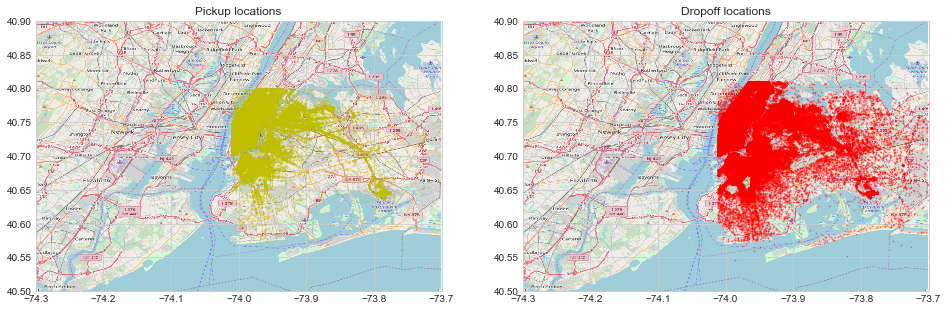

In [78]:
# plot training data on map zoomed in
plot_on_map(data_prepared, nyc_zoom, nyc_map_zoom, s=1, alpha=0.3)

### Phase2: Remove geolocations present in water

We see few points where pickup and dropoff locations are in water. We need to remove them since they represent noisy data.

#### Steps performed in order to remove water points:

1. Prepare a boolean  map from the NYC map which differentiate between land and water based on threshold. Here we utilized the aiblog.nl web service to download the boolean map
2. Map longitude and latitude coordinates to xy pixel coordinates of our existing image so that we can filter points based on threshold
3. Perform AND operator on pick up and drop off xy coordinates to select only those points where pickup and drop off both are on land

In [79]:
# Reference: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration/

def lonlat_to_xy(longitude, latitude, dx, dy, BB):
    return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
           (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

def remove_datapoints_from_water(df):
    def lonlat_to_xy(longitude, latitude, dx, dy, BB):
        return (dx*(longitude - BB[0])/(BB[1]-BB[0])).astype('int'), \
               (dy - dy*(latitude - BB[2])/(BB[3]-BB[2])).astype('int')

    # define bounding box
    BB = (-74.5, -72.8, 40.5, 41.8)
    
    # read nyc mask and turn into boolean map with
    # land = True, water = False
    nyc_mask = plt.imread('download/nyc_mask-74.5_-72.8_40.5_41.8.png')[:,:,0] > 0.9
    
    # calculate for each lon,lat coordinate the xy coordinate in the mask map
    pickup_x, pickup_y = lonlat_to_xy(df.pickup_longitude, df.pickup_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)
    dropoff_x, dropoff_y = lonlat_to_xy(df.dropoff_longitude, df.dropoff_latitude, 
                                      nyc_mask.shape[1], nyc_mask.shape[0], BB)    
    # calculate boolean index
    idx = nyc_mask[pickup_y, pickup_x] & nyc_mask[dropoff_y, dropoff_x]
    
    # return only datapoints on land
    return df[idx]

In [80]:
print('Before removing water geo points: %d' % len(data_prepared))
data_prepared = remove_datapoints_from_water(data_prepared)
print('After removing water geo points: %d' % len(data_prepared))

Before removing water geo points: 874468
After removing water geo points: 874431


#### Lets plot the map now after removing water geo location points

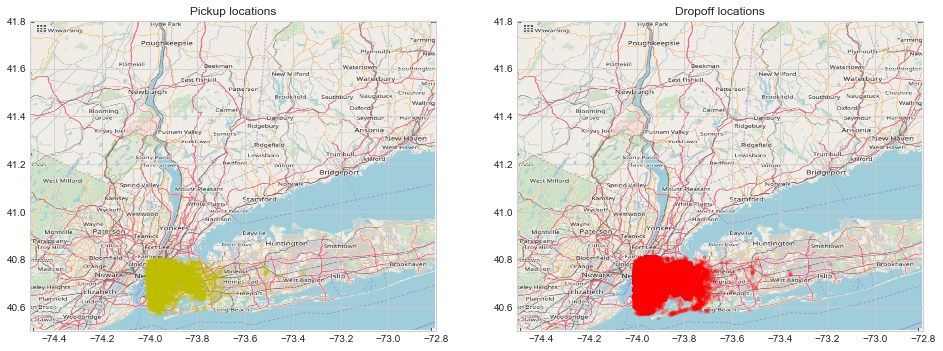

In [81]:
plot_on_map(data_prepared, nyc, nyc_map)

The map shows that there are no longer data points in water. 

### Plot the Empirical cumulative distribution function

The empirical cumulative distribution function provides a graphical representation of the probability distribution of a random vector without implying any prior assumption concerning the form of this distribution. We can view the percentile distribution of the variable and see if there still are any outliers in our target variable. More details about [ECDF](http://openturns.github.io/openturns/master/theory/data_analysis/empirical_cdf.html)

In [82]:
# Declaring CDF fxn 

def ecdf(x):
    """Empirical cumulative distribution function of a variable"""
    # Sort in ascending order
    x = np.sort(x)
    n = len(x)
    
    # Go from 1/n to 1
    y = np.arange(1, n + 1, 1) / n
    
    return x, y

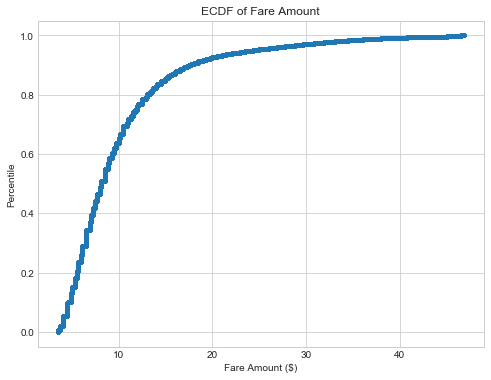

In [83]:
# Visualizing the CDF fxn to check if we still have outliers 
xs, ys = ecdf(data_prepared['fare_amount'])
plt.figure(figsize = (8, 6))
plt.plot(xs, ys, '.')
plt.ylabel('Percentile'); plt.title('ECDF of Fare Amount'); plt.xlabel('Fare Amount ($)');

__CDF graph shows we have close to 90 percentile of data have fare less than or equals to 20 dollars. Please note this is just for one million sample size.__

__Now all columns look much better, let's write a wrapper class which can be utilized in pipeline.__

In [84]:
sampletrain.shape

(1000000, 7)

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, low=0.02, high=0.98): 
        """

        A class to deal with missing values and remove outliers.

        """
        self.low = low
        self.high = high 
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        
        X = X[X.fare_amount>0]
        
        # drop na rows
        X = X.dropna(how='any', axis='rows')
    
        #remove outliers
        X = X[(X.fare_amount >= X.fare_amount.quantile(self.low))
        & (X.fare_amount <= X.fare_amount.quantile(self.high))
     
        & (X.pickup_longitude >= X.pickup_longitude.quantile(self.low))
        & (X.pickup_longitude <= X.pickup_longitude.quantile(self.high))
    
        & (X.pickup_latitude  >= X.pickup_latitude.quantile(self.low))
        & (X.pickup_latitude  <= X.pickup_latitude.quantile(self.high))
       
        & (X.dropoff_longitude  >= X.dropoff_longitude.quantile(self.low))
        & (X.dropoff_longitude  <= X.dropoff_longitude.quantile(self.high))
       
        & (X.dropoff_latitude  >= X.dropoff_latitude.quantile(self.low))
        & (X.dropoff_latitude  <= X.dropoff_latitude.quantile(self.high))
      
        & (X.passenger_count  >= X.passenger_count.quantile(self.low))
        & (X.passenger_count  <= X.passenger_count.quantile(self.high))
       
       ]
        
        # remove water data points
        X = remove_datapoints_from_water(X)
        
        return X

In [86]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
        ('data_cleaner', DataCleaner(low=0.02,high=0.98)),
        
    ])

prepared_data = pipeline.fit_transform(sampletrain)

In [87]:
prepared_data.shape

(874431, 7)

In [88]:
prepared_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [89]:
prepared_data.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
count,874431.000000,874431.000000,874431.000000,874431.000000,874431.000000,874431.000000
mean,-73.976856,40.751314,-73.975425,40.750901,1.690944,10.195422
std,0.029117,0.023076,0.028741,0.026091,1.306221,6.740948
min,-74.010257,40.570342,-74.011853,40.557236,1.000000,3.500000
25%,-73.991890,40.738035,-73.991220,40.737153,1.000000,6.000000
50%,-73.982195,40.753590,-73.980740,40.753860,1.000000,8.100000
75%,-73.969701,40.766690,-73.966864,40.767377,2.000000,12.000000
max,-73.183408,40.799662,-73.189983,40.810127,6.000000,46.830000


## Find Correlation

fare_amount          1.000000
pickup_longitude     0.366144
dropoff_longitude    0.364644
passenger_count      0.012426
pickup_latitude     -0.116981
dropoff_latitude    -0.199089
Name: fare_amount, dtype: float64


Text(0.5,1,'Heatmap of Correlation Matrix')

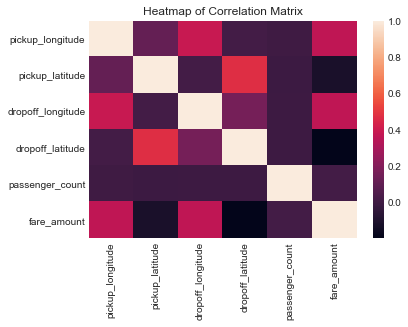

In [90]:
corr_matrix = prepared_data.corr()
print(corr_matrix["fare_amount"].sort_values(ascending=False))
sns.heatmap(corr_matrix, 
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

As we have a limited set of features, the correlation plot shows that longitude is most highly correlated with the target column.

# Feature Engineering

Let's derive some new features. Feature engineering is the process of creating new features out of an existing dataset and is one of the most important step of the machine learning pipeline. Since we know that the fare amount of the taxi ride is proportional to the distance traveled, let us derive the distance feature using the pickup and dropoff coordinates. We will use Haversine formula to calculate the distance. The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. And the great-circle distance or orthodromic distance is the shortest distance between two points on the surface of a sphere, measured along the surface of the sphere (as opposed to a straight line through the sphere's interior). As we found that, haversine formula is mostly used for navigation purpose, this might give a better approximation of the distance traveled.  More [info here on haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [91]:
# Radius of the earth in kilometers
#R = 6378

# Radius of the earth in miles
R = 3959

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    source: https://stackoverflow.com/a/29546836

    """
    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to kilometers
    km = R * c
    
    return km

In [92]:
train_df = prepared_data.copy()

In [93]:
train_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [94]:
train_df['haversine'] =  haversine_np(train_df['pickup_longitude'], train_df['pickup_latitude'],
                         train_df['dropoff_longitude'], train_df['dropoff_latitude']) 

In [95]:
train_df.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340


## Phase2: Histogram of distance in miles

Text(0.5,1,'Distribution of haversine distance in miles')

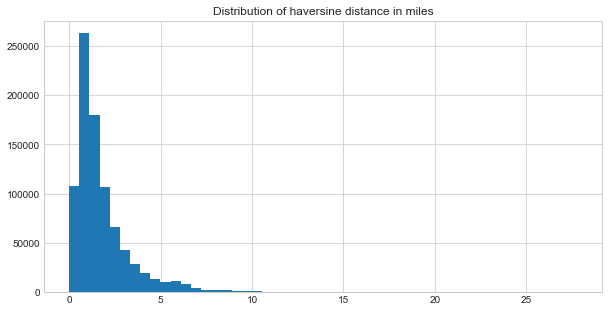

In [96]:
train_df.haversine.hist(bins=50, figsize=(10,5))
plt.title('Distribution of haversine distance in miles')

It seems that most rides are short rides with a peak between 10-15 miles. This peak could be due to the fixed distance like airport trips.

In [97]:
train_df.haversine.describe()

count    874431.000000
mean          1.795571
std           1.630143
min           0.000000
25%           0.778119
50%           1.285477
75%           2.208660
max          27.743169
Name: haversine, dtype: float64

Let's see the number of rows with less than 0.05 miles and see if we can remove them.

In [98]:
len(train_df[train_df.haversine < 0.05])

9698

We have 9698 rows with less than 0.05 miles. Let's remove those rows.

In [99]:
# Let's drop rows where distance is less than 0.05 miles
prep_data = train_df[train_df.haversine >= 0.05]

In [100]:
prep_data.shape

(864733, 8)

Now let's plot to see the relation between distance and fare

## Phase2: Plot distance Vs fare

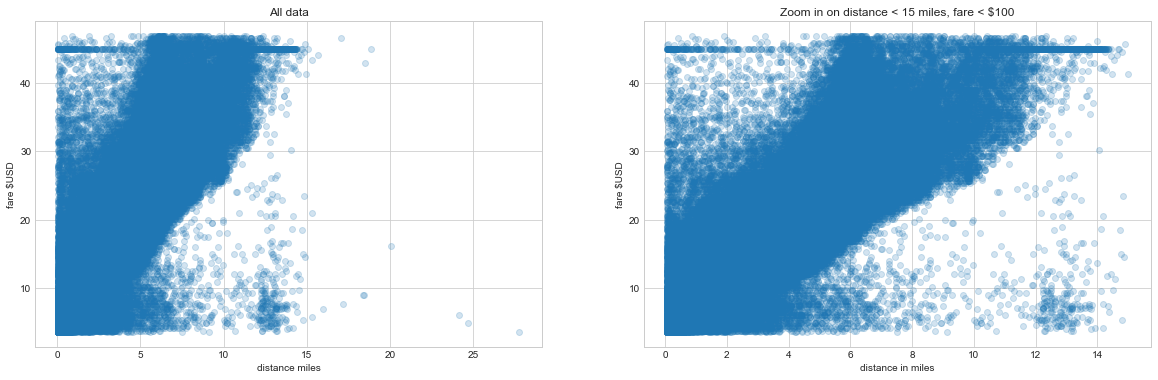

In [101]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(20,6))
axs[0].scatter(prep_data.haversine, prep_data.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance miles')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (prep_data.haversine < 15) & (prep_data.fare_amount < 100)
axs[1].scatter(prep_data[idx].haversine, prep_data[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance in miles')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 miles, fare < $100');

From this plot we see that:
* there are some distances (greater than 20) but will relatively low fare. Perhaps they are discounted trips?
* overall there also seems to be a positive correlation between distance and fare amount.
* the horizontal lines in the zoomed in plot shows the fixed fare amounts which might indicate the to/from airport trips.

**Phase2: Now let's add another column 'distance_to_center' which gives us the distance from center of new york city to the distance in miles.**
Reference: https://www.kaggle.com/breemen/nyc-taxi-fare-data-exploration/

In [102]:
# add new column to dataframe with distance to center of NYC
nyc_coordinates = (40.71,-74.00)
prep_data['distance_to_center'] = haversine_np(nyc_coordinates[1], nyc_coordinates[0], prep_data.pickup_longitude, prep_data.pickup_latitude)

In [103]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768


## Phase2: Plot distance to center Vs fare

Plotting distance to center vs distance in miles Vs the fare amount should tell us something if the fare price varies with distance and may help us decide whether to remove the airport datapoints.

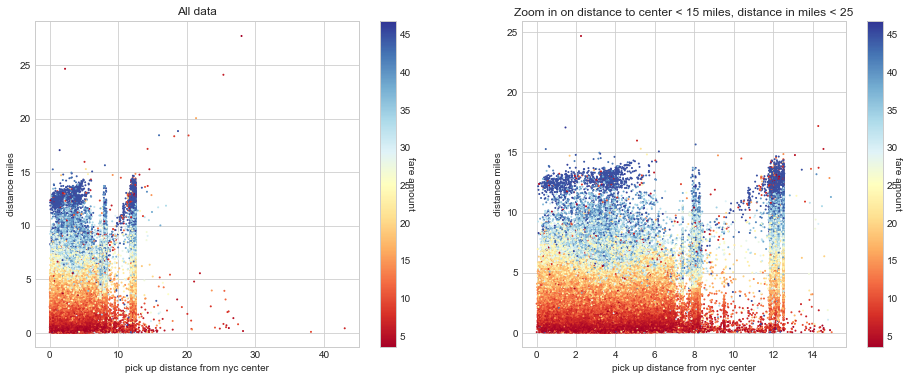

In [106]:
# scatter plot distance - fare
fig, axs = plt.subplots(1, 2, figsize=(16,6))
sc = axs[0].scatter(prep_data.distance_to_center, prep_data.haversine, s=1, c=np.clip(prep_data.fare_amount, 0, 100), alpha=1.0, cmap='RdYlBu')
axs[0].set_ylabel('distance miles')
axs[0].set_xlabel('pick up distance from nyc center')
axs[0].set_title('All data')
cbar = fig.colorbar(sc, ax=axs[0])
cbar.ax.set_ylabel('fare amount', rotation=270)

# zoom in on part of data
idx = (prep_data.distance_to_center < 15) & (prep_data.haversine < 25)
sc = axs[1].scatter(prep_data[idx].distance_to_center, prep_data[idx].haversine, s=1, c=np.clip(prep_data[idx].fare_amount, 0, 100), alpha=1.0, cmap='RdYlBu')
axs[1].set_ylabel('distance miles')
axs[1].set_xlabel('pick up distance from nyc center')
axs[1].set_title('Zoom in on distance to center < 15 miles, distance in miles < 25')
cbar = fig.colorbar(sc, ax=axs[1])
cbar.ax.set_ylabel('fare amount', rotation=270);

From the above plots we see that, there are a lot of datapoints with fare amount between $40$-$50$ with distance between 10-14 miles of NYC center of distance of trip. Let's see if we can remove these datapoints as these are fixed fare amounts. 

## Phase2: Calculate distance using Minkowski method

In [107]:
# Let's also calculate the Manhattan and Euclidean distances
# when p=1, it is Manhattan distance and when p=2 it is Euclidean distance
def minkowski_distance(x1, x2, y1, y2, p):
    return ((abs(x2 - x1) ** p) + (abs(y2 - y1)) ** p) ** (1 / p)

In [108]:
prep_data['manhattan'] = minkowski_distance(prep_data['pickup_longitude'], prep_data['dropoff_longitude'],
                                       prep_data['pickup_latitude'], prep_data['dropoff_latitude'], 1)

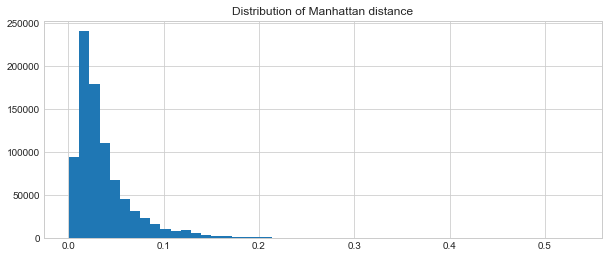

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
prep_data.manhattan.hist(bins=50, figsize=(10,4))
plt.title("Distribution of Manhattan distance")
plt.show()

In [110]:
prep_data.manhattan.describe()

count    864733.000000
mean          0.038320
std           0.035465
min           0.000790
25%           0.016656
50%           0.027290
75%           0.046494
max           0.533127
Name: manhattan, dtype: float64

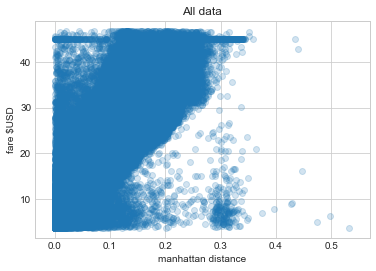

In [111]:
# scatter plot manhattan distance - fare
fig = plt.figure()
plt.scatter(prep_data.manhattan, prep_data.fare_amount, alpha=0.2)
plt.xlabel('manhattan distance')
plt.ylabel('fare $USD')
plt.title('All data');

In [112]:
prep_data['euclidean'] = minkowski_distance(prep_data['pickup_longitude'], prep_data['dropoff_longitude'],
                                       prep_data['pickup_latitude'], prep_data['dropoff_latitude'], 2)

In [113]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,euclidean
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,0.047917
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,0.033450
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,0.016513
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,0.019344
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,0.005872


In [114]:
prep_data.euclidean.describe()

count    864733.000000
mean          0.029877
std           0.028188
min           0.000733
25%           0.013031
50%           0.021195
75%           0.035561
max           0.529880
Name: euclidean, dtype: float64

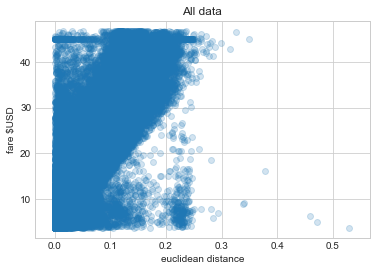

In [115]:
# scatter plot Euclidean distance - fare
fig = plt.figure()
plt.scatter(prep_data.euclidean, prep_data.fare_amount, alpha=0.2)
plt.xlabel('euclidean distance')
plt.ylabel('fare $USD')
plt.title('All data');

We see from the above scatter plots that all distances are linearly related to the fare amount.

## Phase2: Calculate airport distances

We should also consider adding few more features which can be distances from popular New York airports:

    John F. Kennedy International Airport (JFK)
    Newark Liberty International Airport (EWR)
    LaGuardia Airport (LGA)
    
This may allow for better predictability of our model.

In [116]:
prep_data.shape

(864733, 11)

In [117]:
def add_distances_from_airport(dataset):
    #coordinates of all these airports
    jfk_coords = (40.639722, -73.778889)
    ewr_coords = (40.6925, -74.168611)
    lga_coords = (40.77725, -73.872611)

    dataset['pickup_jfk_distance'] = haversine_np(jfk_coords[1], jfk_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_jfk_distance'] = haversine_np(jfk_coords[1], jfk_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)
    
    dataset['pickup_ewr_distance'] = haversine_np(ewr_coords[1], ewr_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_ewr_distance'] = haversine_np(ewr_coords[1], ewr_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)
    
    dataset['pickup_lga_distance'] = haversine_np(lga_coords[1], lga_coords[0], dataset.pickup_longitude, dataset.pickup_latitude)
    dataset['dropoff_lga_distance'] = haversine_np(lga_coords[1], lga_coords[0], dataset.dropoff_longitude, dataset.dropoff_latitude)
    return dataset

In [118]:
prep_data = add_distances_from_airport(prep_data)

In [119]:
prep_data.shape

(864733, 17)

In [120]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,euclidean,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,0.047917,14.825809,13.873856,12.762623,10.208569,5.259472,6.472253
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,0.033450,13.253746,13.914821,9.290879,10.716195,7.306061,6.069034
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,0.016513,14.455372,14.506686,11.635426,12.589192,5.667262,5.113124
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,0.019344,13.070368,13.408644,9.058044,9.760714,7.624509,6.807695
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,0.005872,13.821556,13.646517,9.570368,9.888708,7.022760,6.706591


 **Now let's derive the timestamp related features.**

In [121]:
# Create new features (based on timestamp)
prep_data["hour"] = [t.hour for t in pd.DatetimeIndex(prep_data.pickup_datetime)]
prep_data["day"] = [t.dayofweek for t in pd.DatetimeIndex(prep_data.pickup_datetime)]
prep_data["month"] = [t.month for t in pd.DatetimeIndex(prep_data.pickup_datetime)]
prep_data['year'] = [t.year for t in pd.DatetimeIndex(prep_data.pickup_datetime)]

In [122]:
prep_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,haversine,distance_to_center,manhattan,...,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance,hour,day,month,year
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5,3.122720,6.335151,0.065634,...,14.825809,13.873856,12.762623,10.208569,5.259472,6.472253,23,5,8,2012
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5,2.244191,1.616934,0.043383,...,13.253746,13.914821,9.290879,10.716195,7.306061,6.069034,20,3,12,2014
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3,0.988520,5.104784,0.023269,...,14.455372,14.506686,11.635426,12.589192,5.667262,5.113124,20,3,3,2012
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0,1.306093,1.070402,0.024587,...,13.070368,13.408644,9.058044,9.760714,7.624509,6.807695,11,4,12,2014
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5,0.318340,2.603768,0.007414,...,13.821556,13.646517,9.570368,9.888708,7.022760,6.706591,13,5,5,2009


## Perform EDA on timestamp features

In [123]:
trips_year_fareamount=prep_data.groupby(['year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

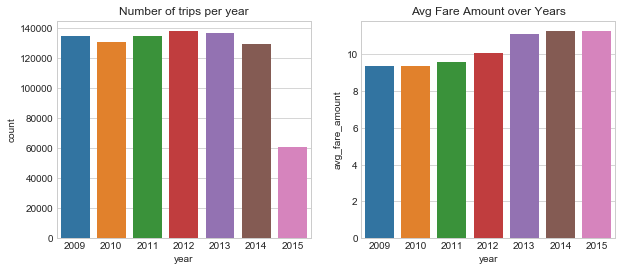

In [124]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='year', data=prep_data)
plt.title('Number of trips per year')

plt.subplot(1,2,2)
# Let's plot number of trips Vs avg. fare 
sns.barplot(x='year', y='avg_fare_amount', data=trips_year_fareamount).set_title("Avg Fare Amount over Years");

From the above plot we see that the avg. fare has increased over the years.

Text(0.5,1,'Number of trips per month')

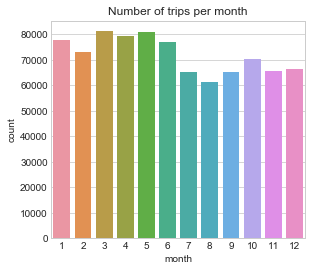

In [125]:
trips_month_fareamount=prep_data.groupby(['month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='month', data=prep_data)
plt.title('Number of trips per month')

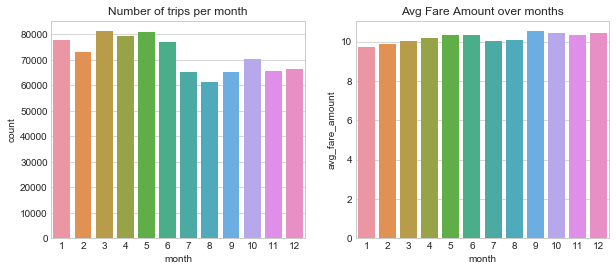

In [126]:
trips_month_fareamount=prep_data.groupby(['month'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='month', data=prep_data)
plt.title('Number of trips per month')

plt.subplot(1,2,2)
# Let's plot number of trips Vs avg. fare 
sns.barplot(x='month', y='avg_fare_amount', data=trips_month_fareamount).set_title("Avg Fare Amount over months");

From the above plot we see that, avg. fares across months is fairly constant although the number of trips starts to decrease after June. There's one peak in November which could mean passengers taking taxis to airport/ other locations during Thanksgiving/ holiday season. 

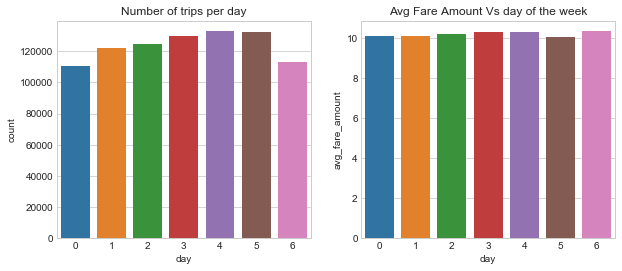

In [127]:
trips_day_fareamount=prep_data.groupby(['day'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.countplot(x='day', data=prep_data)
plt.title('Number of trips per day')

plt.subplot(1,2,2)
# Let's plot number of trips Vs avg. fare 
sns.barplot(x='day', y='avg_fare_amount', data=trips_day_fareamount).set_title("Avg Fare Amount Vs day of the week");

With Monday=0 and Sunday=6, we see that the avg.fare amount across day of the week is farely constant except Saturday. Although the number of trips on Sunday and Monday is fairly less, the avg.fare amount is pretty high on these days.

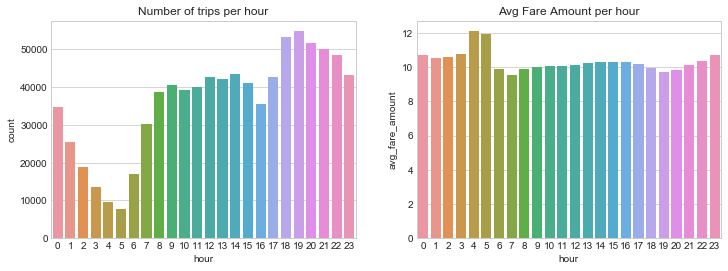

In [128]:
trips_hour_fareamount=prep_data.groupby(['hour'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.countplot(x='hour', data=prep_data)
plt.title('Number of trips per hour')

plt.subplot(1,2,2)
# Let's plot number of trips Vs avg. fare 
sns.barplot(x='hour', y='avg_fare_amount', data=trips_hour_fareamount).set_title("Avg Fare Amount per hour");

The above plot shows that the avg. fare amount during wee hours of the morning are higher, which might indicate the availibility of taxis is low at this time and hence the fare is relatively higher at this time. The number of trips are highest during late evening hours.

## Find correlation after feature engineering

In [129]:
corr_matrix = prep_data.corr()
corr_matrix["fare_amount"].sort_values(ascending=False)

fare_amount             1.000000
euclidean               0.882450
haversine               0.875900
manhattan               0.859176
pickup_longitude        0.370805
dropoff_longitude       0.369284
pickup_ewr_distance     0.309547
dropoff_ewr_distance    0.292884
distance_to_center      0.237684
year                    0.113426
month                   0.027612
passenger_count         0.013316
day                     0.005883
hour                   -0.014984
dropoff_lga_distance   -0.062610
pickup_latitude        -0.114952
pickup_lga_distance    -0.129926
dropoff_latitude       -0.198929
pickup_jfk_distance    -0.361402
dropoff_jfk_distance   -0.407082
Name: fare_amount, dtype: float64

Text(0.5,1,'Heatmap of Correlation Matrix')

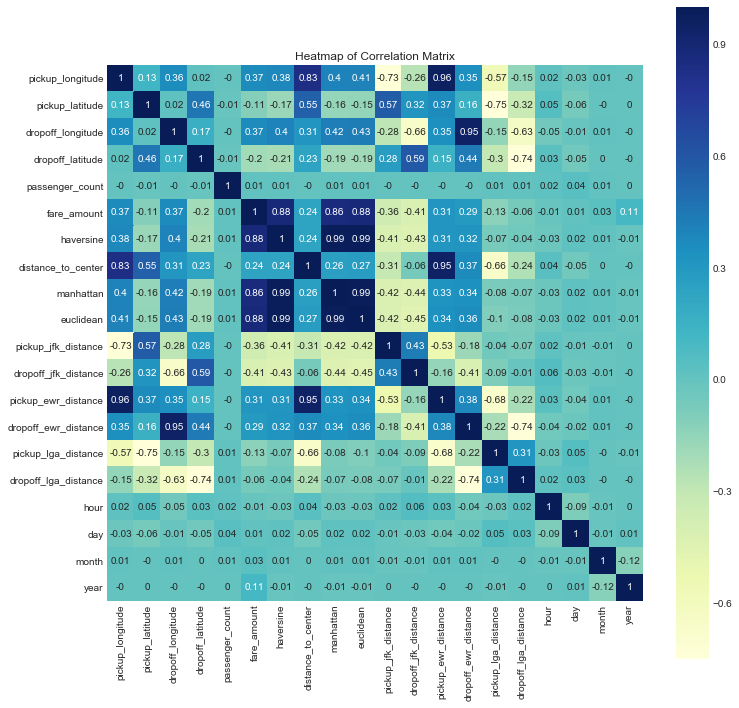

In [130]:
plt.figure(figsize = (12,12))
sns.heatmap(np.round(corr_matrix, 2), square=True, annot=True, cmap="YlGnBu",
            xticklabels=corr_matrix.columns.values,
            yticklabels=corr_matrix.columns.values)
plt.title('Heatmap of Correlation Matrix')

In [131]:
prep_data.shape

(864733, 21)

## Wrap feature engineering steps in a pipeline 

Now let us add all of the steps of feature engineering into a pipeline. 

The below class is used for deriving new features out of our existing numerical features. We are deriving the timestamp related features (hour, day, month and year) and distance features using Haversine formula and Minkowski formula based on latitude and longitude columns. 

In [132]:
prepared_data.head()

,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount
2,2012-08-11 23:43:19,-73.969091,40.798644,-73.993477,40.757396,1,12.5
3,2014-12-04 20:41:26,-73.999625,40.733399,-73.987364,40.764521,1,14.5
4,2012-03-08 20:40:29,-73.980710,40.782418,-73.968085,40.793062,1,5.3
5,2014-12-19 11:12:00,-74.001232,40.725463,-73.994935,40.743753,1,10.0
6,2009-05-09 13:05:00,-74.000990,40.747675,-73.995413,40.749512,3,4.5


In [7]:
def extract_date(X_val, dt_ix):
    h = [t.hour for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    d = [t.dayofweek for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    m = [t.month for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    y = [t.year for t in pd.DatetimeIndex(X_val[:, dt_ix])]
    return h, d, m, y

# Calculate distance between pickup and dropoff using Haversine formula
def haversine_distance(X_val, lon1_idx, lat1_idx, lon2_idx, lat2_idx, r):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    lon1 = X_val[:, lon1_idx].astype(float)
    lat1 = X_val[:, lat1_idx].astype(float)
    lon2 = X_val[:, lon2_idx].astype(float)
    lat2 = X_val[:, lat2_idx].astype(float)

    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to miles
    miles = r * c

    return miles

# Calculate distance between pickup and dropoff using Haversine formula
def calculate_airport_distance(X_val, lon1, lat1, lon2_idx, lat2_idx, r):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    source: https://stackoverflow.com/a/29546836

    """
    lon2 = X_val[:, lon2_idx].astype(float)
    lat2 = X_val[:, lat2_idx].astype(float)

    # Convert latitude and longitude to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    # Find the differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Apply the formula 
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # Calculate the angle (in radians)
    c = 2 * np.arcsin(np.sqrt(a))
    # Convert to miles
    miles = r * c

    return miles

def minkowski_distance(X_val, x1, x2, y1, y2, p):
    """
    Function to calculate the relative distance based on 
    Euclidean and Manhattan formula.
    
    """
    return ((abs(X_val[:, x2] - X_val[:, x1]) ** p) + (abs(X_val[:, y2] - X_val[:, y1])) ** p) ** (1 / p)

### Phase2: Class to derive new features

In [276]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
datetime_ix, lon1_ix, lat1_ix, lon2_ix, lat2_ix = 0, 1, 2, 3, 4

# Radius of the earth in miles
R = 3959
nyc_coordinates = (40.71, -74.00)
jfk_coords = (40.639722, -73.778889)
ewr_coords = (40.6925, -74.168611)
lga_coords = (40.77725, -73.872611)

col=['pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude', 
    'passenger_count','fare_amount', 'hour', 'day', 
    'month', 'year', 'haversine', 'distance_to_center', 
    'pickup_jfk_distance', 'dropoff_jfk_distance', 
    'pickup_ewr_distance', 'dropoff_ewr_distance', 
    'pickup_lga_distance', 'dropoff_lga_distance']


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,col): # no *args or **kargs
        """

        A class to derive new features from numerical features.

        """
        self.col=col
    def fit(self, X, y=None):
        
        return self  # nothing else to do
    
    def transform(self, X, y=None):
            
        hour, day, month, year = extract_date(X, datetime_ix)
        haversine = haversine_distance(X, lon1_ix, lat1_ix, lon2_ix, lat2_ix, R)
        
        #manhattan = minkowski_distance(X, lon1_ix, lon2_ix, lat1_ix, lat2_ix, 1)
        #euclidean = minkowski_distance(X, lon1_ix, lon2_ix, lat1_ix, lat2_ix, 2)
        
        distance_to_center = calculate_airport_distance(X, nyc_coordinates[1], nyc_coordinates[0], lon1_ix, lat1_ix, R)
        
        pickup_jfk_distance = calculate_airport_distance(X, jfk_coords[1], jfk_coords[0], lon1_ix, lat1_ix, R)
        dropoff_jfk_distance = calculate_airport_distance(X, jfk_coords[1], jfk_coords[0], lon2_ix, lat2_ix, R)
    
        pickup_ewr_distance = calculate_airport_distance(X, ewr_coords[1], ewr_coords[0], lon1_ix, lat1_ix, R)
        dropoff_ewr_distance = calculate_airport_distance(X, ewr_coords[1], ewr_coords[0], lon2_ix, lat2_ix, R)
    
        pickup_lga_distance = calculate_airport_distance(X, lga_coords[1], lga_coords[0], lon1_ix, lat1_ix, R)
        dropoff_lga_distance = calculate_airport_distance(X, lga_coords[1], lga_coords[0], lon2_ix, lat2_ix, R)
        
        X = np.delete(X, 0, axis=1)
        
        feat_arr = np.c_[X, hour, day, month, year, haversine, distance_to_center, 
                     pickup_jfk_distance, dropoff_jfk_distance, pickup_ewr_distance, dropoff_ewr_distance, 
                     pickup_lga_distance, dropoff_lga_distance]  #manhattan, euclidean, excluded
        
        feat_df = pd.DataFrame(data=feat_arr,columns=self.col)
        feat_df = feat_df.infer_objects()
        
        return feat_df

In [277]:
num_attribs = ['pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'fare_amount']

feature_eng_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder(col))
    ])

sampletrain_prepared = feature_eng_pipeline.fit_transform(prepared_data)

In [278]:
sampletrain_prepared.shape

(874431, 18)

In [261]:
sampletrain_prepared.dtypes

pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
passenger_count           int64
fare_amount             float64
hour                      int64
day                       int64
month                     int64
year                      int64
haversine               float64
distance_to_center      float64
pickup_jfk_distance     float64
dropoff_jfk_distance    float64
pickup_ewr_distance     float64
dropoff_ewr_distance    float64
pickup_lga_distance     float64
dropoff_lga_distance    float64
dtype: object

### Phase2: Class for data cleanup after feature engineering

In [262]:
class DataCleaner2(BaseEstimator, TransformerMixin):
    def __init__(self): 
        """

        A class to filter distances less than 0.05 miles.

        """ 
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):    
        X = X[X.haversine >= 0.05]
        return X

In [301]:
filter_distance_pipeline = Pipeline([
        ('data_cleaner', DataCleaner2()),
        #('std_scaler', StandardScaler()),
    ])

train_prep = filter_distance_pipeline.fit_transform(sampletrain_prepared)

In [302]:
train_prep.shape

(864733, 18)

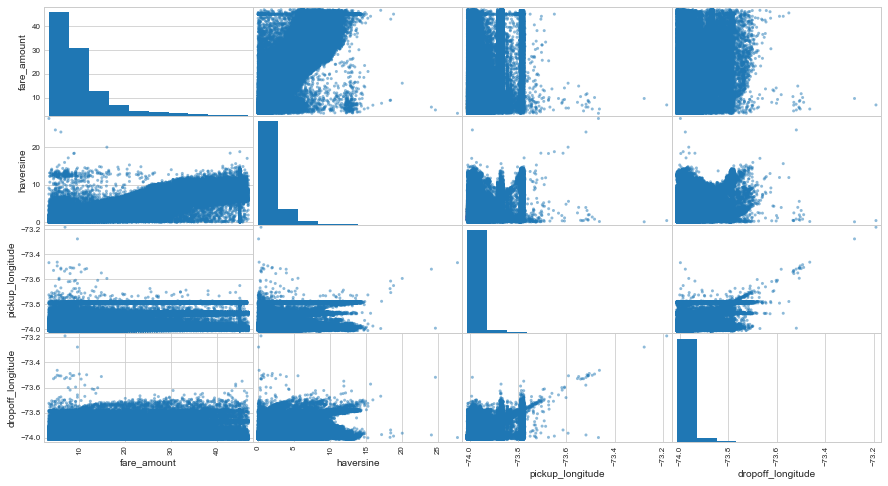

In [304]:
from pandas.plotting import scatter_matrix

# Top four correlated inputs with fare_amount
attributes = ["fare_amount", "haversine", "pickup_longitude", "dropoff_longitude"]
scatter_matrix(train_prep[attributes], figsize=(15, 8));

# Feature Selection

## Using SelectKBest technique

In [265]:
train_prep.shape

(864733, 18)

In [266]:
train_prep.dtypes

pickup_longitude        float64
pickup_latitude         float64
dropoff_longitude       float64
dropoff_latitude        float64
passenger_count           int64
fare_amount             float64
hour                      int64
day                       int64
month                     int64
year                      int64
haversine               float64
distance_to_center      float64
pickup_jfk_distance     float64
dropoff_jfk_distance    float64
pickup_ewr_distance     float64
dropoff_ewr_distance    float64
pickup_lga_distance     float64
dropoff_lga_distance    float64
dtype: object

In [267]:
from sklearn.feature_selection import SelectKBest, f_regression
y = train_prep['fare_amount']
X = train_prep.drop(['fare_amount'], axis=1)

In [240]:
print(X.shape)
print(y.shape)

(864733, 17)
(864733,)


In [241]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,haversine,distance_to_center,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
0,-73.969091,40.798644,-73.993477,40.757396,1,23,5,8,2012,3.122720,6.335151,14.825809,13.873856,12.762623,10.208569,5.259472,6.472253
1,-73.999625,40.733399,-73.987364,40.764521,1,20,3,12,2014,2.244191,1.616934,13.253746,13.914821,9.290879,10.716195,7.306061,6.069034
2,-73.980710,40.782418,-73.968085,40.793062,1,20,3,3,2012,0.988520,5.104784,14.455372,14.506686,11.635426,12.589192,5.667262,5.113124
3,-74.001232,40.725463,-73.994935,40.743753,1,11,4,12,2014,1.306093,1.070402,13.070368,13.408644,9.058044,9.760714,7.624509,6.807695
4,-74.000990,40.747675,-73.995413,40.749512,3,13,5,5,2009,0.318340,2.603768,13.821556,13.646517,9.570368,9.888708,7.022760,6.706591


In [242]:
from sklearn.feature_selection import SelectKBest, f_regression

# SCORE  linear regression input variables using correlation producing F scores and corresponding p-values
# K is used select top k rated input features
def select_kbest_reg(data_frame, target, k=5):
    """
    Selecting K-Best features regression
    :param data_frame: A pandas dataFrame with the training data
    :param target: target variable name in DataFrame
    :param k: desired number of features from the data
    :returns feature_scores: scores for each feature in the data as 
    pandas DataFrame
    """
    feat_selector = SelectKBest(f_regression, k=k)
    _ = feat_selector.fit(data_frame.drop(target, axis=1), data_frame[target])
    
    feat_scores = pd.DataFrame()
    feat_scores["F Score"] = feat_selector.scores_
    feat_scores["P Value"] = feat_selector.pvalues_
    feat_scores["Support"] = feat_selector.get_support()
    feat_scores["Attribute"] = data_frame.drop(target, axis=1).columns
    
    return feat_scores

In [243]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

df = pd.DataFrame(X_train, columns=X_train.columns).copy()
df["fare_amount"] = y_train

per_feat = select_kbest_reg(df, 'fare_amount', k=5)
per_feat_sorted = per_feat.sort_values(["F Score", "P Value"], ascending=[False, False])
top_k_feature_indices = per_feat_sorted['Attribute'].values.flatten()
print("\n Feature Score for a linear regression using correlation\n")
print(per_feat_sorted)   

#print(np.linalg.norm(y_train))


 Feature Score for a linear regression using correlation

         F Score        P Value  Support             Attribute
9   2.273438e+06   0.000000e+00     True             haversine
12  1.376179e+05   0.000000e+00     True  dropoff_jfk_distance
0   1.094752e+05   0.000000e+00     True      pickup_longitude
2   1.091852e+05   0.000000e+00     True     dropoff_longitude
11  1.032478e+05   0.000000e+00     True   pickup_jfk_distance
13  7.263225e+04   0.000000e+00    False   pickup_ewr_distance
14  6.466670e+04   0.000000e+00    False  dropoff_ewr_distance
10  4.089455e+04   0.000000e+00    False    distance_to_center
3   2.848474e+04   0.000000e+00    False      dropoff_latitude
15  1.210286e+04   0.000000e+00    False   pickup_lga_distance
1   9.152901e+03   0.000000e+00    False       pickup_latitude
8   8.967197e+03   0.000000e+00    False                  year
16  2.743613e+03   0.000000e+00    False  dropoff_lga_distance
7   5.012378e+02  5.600476e-111    False                 mo

The features that are selected by SelectKBest are the same features that were also most highly correlated, which were shown on finding the correlation using heatmap. 

## Phase2: Plot input variable importance

In [244]:
feature_importances = per_feat[["F Score", "Attribute"]] #Order of appearance in dataframe
#print(feature_importances)
feature_importances_sorted = per_feat_sorted[["F Score", "Attribute"]] #Order of appearence in dataframe
feature_importances_sorted

,F Score,Attribute
9,2.273438e+06,haversine
12,1.376179e+05,dropoff_jfk_distance
0,1.094752e+05,pickup_longitude
2,1.091852e+05,dropoff_longitude
11,1.032478e+05,pickup_jfk_distance
13,7.263225e+04,pickup_ewr_distance
14,6.466670e+04,dropoff_ewr_distance
10,4.089455e+04,distance_to_center
3,2.848474e+04,dropoff_latitude
15,1.210286e+04,pickup_lga_distance


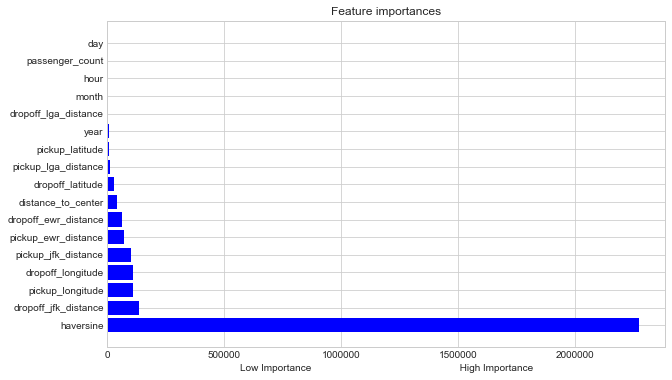

In [245]:
# Plot the feature importance
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=[10,6]) 
plt.title("Feature importances")
sortedNames = np.array(feature_importances_sorted)[:, 1]
sortedImportances = np.array(feature_importances_sorted)[:, 0]

#plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Low Importance                                                      High Importance')
plt.grid(True)
plt.show()

In [246]:
from sklearn.base import BaseEstimator, TransformerMixin

# find the indices to the top ranking input features based on importance 
#    arr is an array of feature importances in order of the input data matrix X
#    k is the number of features to be selected
#
# Note: this feature selector assumes that you have already computed the feature importances 
# We did so in the cell above with the feature importance scores stored in Kbest.scores_ 

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    # select the columns of data matrix of the selected input features 
    def transform(self, X):
        return X[:, self.feature_indices_]

In [247]:
# flatten the feature score values
featureScores = feature_importances[["F Score"]].values.flatten()
print(featureScores)

[1.09475195e+05 9.15290089e+03 1.09185167e+05 2.84847371e+04
 1.13656661e+02 1.67323313e+02 3.26241071e+01 5.01237778e+02
 8.96719682e+03 2.27343796e+06 4.08945500e+04 1.03247767e+05
 1.37617890e+05 7.26322460e+04 6.46666991e+04 1.21028645e+04
 2.74361317e+03]


In [291]:
# Feature selection in a pipeline
scaler_pipeline = Pipeline([
        ('data_cleaner', DataCleaner2()),
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10))

    ])

trainprep = scaler_pipeline.fit_transform(sampletrain_prepared)

In [292]:
trainprep.shape

(864733, 10)

# Model Evaluation

## Build Pipelines

Lets create a full pipeline with predictor. <p>
This pipeline will - 
    - create additional features
    - stardardize data with mean of zero and std.deviation of one.  
    - run predictor on transformed data.

In [310]:
num_attribs = ['pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'fare_amount', 
    ]

features=['pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude', 
    'passenger_count','fare_amount', 'hour', 'day', 
    'month', 'year', 'haversine', 'distance_to_center', 
    'pickup_jfk_distance', 'dropoff_jfk_distance', 
    'pickup_ewr_distance', 'dropoff_ewr_distance', 
    'pickup_lga_distance', 'dropoff_lga_distance']

dataprep_pipeline = Pipeline([
        ('data_cleaner', DataCleaner(low=0.02,high=0.98)),
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder(features)),
        ('data_cleaner2', DataCleaner2()),
    ])

In [308]:
predictor_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10)),
        ('predictor', RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=30, max_features=4)) # Best predictor from Phase 1
        ])

In [311]:
prepared_data = dataprep_pipeline.fit_transform(sampletrain)

In [312]:
prepared_data.shape

(864733, 18)

In [313]:
prepared_data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount,hour,day,month,year,haversine,distance_to_center,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
0,-73.969091,40.798644,-73.993477,40.757396,1,12.5,23,5,8,2012,3.122720,6.335151,14.825809,13.873856,12.762623,10.208569,5.259472,6.472253
1,-73.999625,40.733399,-73.987364,40.764521,1,14.5,20,3,12,2014,2.244191,1.616934,13.253746,13.914821,9.290879,10.716195,7.306061,6.069034
2,-73.980710,40.782418,-73.968085,40.793062,1,5.3,20,3,3,2012,0.988520,5.104784,14.455372,14.506686,11.635426,12.589192,5.667262,5.113124
3,-74.001232,40.725463,-73.994935,40.743753,1,10.0,11,4,12,2014,1.306093,1.070402,13.070368,13.408644,9.058044,9.760714,7.624509,6.807695
4,-74.000990,40.747675,-73.995413,40.749512,3,4.5,13,5,5,2009,0.318340,2.603768,13.821556,13.646517,9.570368,9.888708,7.022760,6.706591


## Split the training data

Lets split sample training dataset into train and validation sets for experimentation purpose. We will train our models on train part and validate against val part.

In [314]:
y = prepared_data['fare_amount']
X = prepared_data.drop(['fare_amount'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [315]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((691786, 17), (691786,), (172947, 17), (172947,))

## Baseline model RandomForestRegressor(n_estimators=30, max_features=4)

Let's benchmark our results with Best Regression Model from Phase 1. 

In [316]:
from time import time

start = time()
predictor_pipeline.fit(X_train, y_train)

# Time and score training predictions
cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
lin_scores = cross_val_score(predictor_pipeline, X_train, y_train, scoring="neg_mean_squared_error", cv=cv)
lin_score_train = np.sqrt(-lin_scores.mean())
train_time = np.round(time()-start, 4)

# Time and score test predictions
start = time()
X_val_prediction = predictor_pipeline.predict(X_val)
lin_score_mse  = mean_squared_error(y_val, X_val_prediction)
lin_score_test = np.sqrt(lin_score_mse)
test_time = np.round(time()-start, 4)

In [317]:
results.loc[0] = ["Phase 1 Baseline", lin_score_train, lin_score_test, 
                  "---","---", train_time, test_time, "RandomForestRegressor(n_estimators=30, max_features=4)"]
results 

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 1 Baseline,2.801383,2.785257,---,---,982.2571,0.8155,"RandomForestRegressor(n_estimators=30,max_feat..."


## Hyperparameter Tuning using RandomSearch, GridSearchCV and Statistical significance tests

Now, let's create a wrapper method, which will : <p>
    - execute full pipeline with predictor
    - perform RandomizedSearch for selected features
    - perform GridSearch for selected set of parameters 
    - report best set of parameters
    - calculate RMSE
    - perform t-test with best estimator set
    - populate results table

### Phase2: Perform Random Search

In [318]:
# A Function to execute the random search using RandomizedSearchCV and record the results.
def ConductRandomizedSearch(X_train, y_train, X_val, y_val, i=0, prefix=''):
    
    # Create a list of regressors for our random search experiment
    
    polynomial = Pipeline([
        ("PolynomialFeatures", PolynomialFeatures(degree=2)),
        ("Ridge", Ridge()),
        ])
    
    regressors = [
        #('RandomForestRegressor', RandomForestRegressor(random_state=42,n_jobs=-1)),
        #('LassoRegressor', Lasso(random_state=42)),
        ('SGDRegressor', SGDRegressor(random_state=42)),
        #('SVR', SVR()),
        ('polynomial', polynomial),
        ('GradientBoostingRegressor', GradientBoostingRegressor(max_depth=2)),
        ('XGBRegressor', XGBRegressor(max_depth=3)),
    ]
    
    # Arrange random search parameters for each regressor
    params_grid = {
        #'RandomForestRegressor':{
        #'n_estimators': randint(low=1, high=50), 
        #'max_features': randint(low=3, high=6),
        #},
        #'LassoRegressor':{
        #'max_iter': randint(low=1, high=1000), 
        #'alpha': randint(low=0.01, high=10),
        #},
        'SGDRegressor':{
        'max_iter': randint(low=1, high=1000), 
        },
        #'SVR':{
        #'max_iter': randint(low=1, high=1000), 
        #'C': randint(low=0.01, high=10),
        #},
        'polynomial':{
        'PolynomialFeatures__degree': randint(low=1, high=3), 
        },
        'GradientBoostingRegressor':{
        'n_estimators': randint(low=10, high=1000), 
        #'learning_rate': randint(low=0.1, high=1.0), 
        },
        'XGBRegressor':{
        'n_estimators': randint(low=10, high=1000), 
        },
    }

    
    for (name, regressor) in regressors:
        i += 1
        # Print regressor and parameters
        print('****** START', prefix, name, '*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline      
        full_pipeline_with_predictor = Pipeline([
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10)),
        ("predictor", regressor)
        ])
        
        # Execute the random search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        rnd_search = RandomizedSearchCV(full_pipeline_with_predictor, param_distributions=params, 
                    n_iter=10, scoring='neg_mean_squared_error', cv=5, random_state=42, verbose=1)
        rnd_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = rnd_search.best_score_
        best_train_rmse = np.sqrt(-best_train)

        # Best estimator fitting time
        start = time()
        rnd_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        X_val_prediction = rnd_search.best_estimator_.predict(X_val)
        best_score_mse  = mean_squared_error(y_val, X_val_prediction)
        best_test_rmse = np.sqrt(best_score_mse)
        test_time = round(time() - start, 4)  
        
        # Collect the best parameters found by the random search
        print("Best Parameters:")
        best_parameters = rnd_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_rmse, best_test_rmse, 
                          '---','---', train_time, test_time, json.dumps(param_dump)]

In [320]:
%%time
# This might take a while
ConductRandomizedSearch(X_train, y_train, X_val, y_val, 0, "RandomSearch:") 

****** START RandomSearch: SGDRegressor *****
Parameters:
	max_iter: <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201815CE588>
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 24.4min finished


Best Parameters:
	predictor__max_iter: 861
****** FINISH RandomSearch: SGDRegressor  *****

****** START RandomSearch: polynomial *****
Parameters:
	PolynomialFeatures__degree: <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201815CE4E0>
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished


Best Parameters:
	predictor__PolynomialFeatures__degree: 2
****** FINISH RandomSearch: polynomial  *****

****** START RandomSearch: GradientBoostingRegressor *****
Parameters:
	n_estimators: <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201815CE2B0>
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 126.7min finished


Best Parameters:
	predictor__n_estimators: 870
****** FINISH RandomSearch: GradientBoostingRegressor  *****

****** START RandomSearch: XGBRegressor *****
Parameters:
	n_estimators: <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000201815CE400>
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 94.2min finished


Best Parameters:
	predictor__n_estimators: 870
****** FINISH RandomSearch: XGBRegressor  *****

Wall time: 4h 41min 18s


In [321]:
pd.set_option('display.max_colwidth', -1)
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 1 Baseline,2.801383,2.785257,---,---,982.2571,0.8155,"RandomForestRegressor(n_estimators=30,max_features=4)"
1,RandomSearch:SGDRegressor,3.155830,3.143285,---,---,95.9486,0.0469,"[[""predictor__max_iter"", 861]]"
2,RandomSearch:polynomial,2.959093,2.941486,---,---,2.0158,0.2969,"[[""predictor__PolynomialFeatures__degree"", 2]]"
3,RandomSearch:GradientBoostingRegressor,2.830847,2.814694,---,---,567.5797,0.9376,"[[""predictor__n_estimators"", 870]]"
4,RandomSearch:XGBRegressor,2.780139,2.762571,---,---,385.8015,3.3920,"[[""predictor__n_estimators"", 870]]"


From the above table of random search experiments, we see that XGBoost model looks promising. Now let's perform GridSearch on the same model.

### Perform Grid Search

In [322]:
# A Function to execute the grid search and record the results.
def ConductGridSearch(X_train, y_train, X_val, y_val, i=0, prefix=''):
    
    # Create a list of regressors for our grid search experiment
    regressors = [
        #('RandomForestRegressor', RandomForestRegressor(random_state=42,n_jobs=-1)),
        ('XGBRegressor', XGBRegressor(max_depth=3, n_jobs=-1)),
    ]
    
    # Arrange grid search parameters for each regressor
    params_grid = {
        #'RandomForestRegressor': {
        #    'n_estimators': [10, 50, 100],
        #    'max_features': [4, 5, 6], 
        #},
        'XGBRegressor':{
        'n_estimators': [800, 900, 1000],
        'learning_rate': [0.1, 0.2],
        },
    }
    
    for (name, regressor) in regressors:
        i += 1
        # Print regressor and parameters
        print('****** START', prefix, name,'*****')
        parameters = params_grid[name]
        print("Parameters:")
        for p in sorted(parameters.keys()):
            print("\t"+str(p)+": "+ str(parameters[p]))
        
        # generate the pipeline       
        full_pipeline_with_predictor = Pipeline([
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10)),
        ("predictor", regressor)
        ])
        
        # Execute the grid search
        params = {}
        for p in parameters.keys():
            pipe_key = 'predictor__'+str(p)
            params[pipe_key] = parameters[p] 
            
        grid_search = GridSearchCV(full_pipeline_with_predictor, params, 
                    scoring='neg_mean_squared_error', cv=5, verbose=1)
        grid_search.fit(X_train, y_train)
                
        # Best estimator score
        best_train = grid_search.best_score_
        best_train_score = np.sqrt(-best_train)

        # Best estimator fitting time
        start = time()
        grid_search.best_estimator_.fit(X_train, y_train)
        train_time = round(time() - start, 4)

        # Best estimator prediction time
        start = time()
        X_val_prediction = grid_search.best_estimator_.predict(X_val)
        best_score_mse  = mean_squared_error(y_val, X_val_prediction)
        best_test_rmse = np.sqrt(best_score_mse)
        test_time = round(time() - start, 4)

        # Generate 30 training mse scores with the best estimator and 30-split CV
        cv = ShuffleSplit(n_splits=30, test_size=0.3, random_state=0)
        best_train_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train,scoring='neg_mean_squared_error', cv=cv)
        best_train_rmse = np.sqrt(-best_train_scores.mean())

        # Conduct t-test with baseline lin_reg (control) and best estimator (experiment)
        (t_stat, p_value) = stats.ttest_rel(lin_scores, best_train_scores)
        if p_value > 0.05/2:  #Two sided 
            print('There is no significant difference between the two machine learning pipelines (Accept H0)')
        else:
            print('The two machine learning pipelines are different (reject H0) \n(t_stat, p_value) = (%.2f, %.5f)'%(t_stat, p_value) )
            if t_stat > 0.0: #in the case of regression lower RMSE is better; A is lower 
                print('Machine learning pipeline A is better than B')
            else:
                print('Machine learning pipeline B is better than A')
        
        
        # Collect the best parameters found by the grid search
        print("Best Parameters:")
        best_parameters = grid_search.best_estimator_.get_params()
        param_dump = []
        for param_name in sorted(params.keys()):
            param_dump.append((param_name, best_parameters[param_name]))
            print("\t"+str(param_name)+": " + str(best_parameters[param_name]))
        print("****** FINISH",prefix,name," *****")
        print("")
        
        # Record the results
        results.loc[i] = [prefix+name, best_train_rmse, best_test_rmse, round(p_value,3),round(t_stat,3), train_time, test_time, json.dumps(param_dump)]

Performing GridSearch with wrapper method

In [323]:
%%time
# This might take a while
ConductGridSearch(X_train, y_train, X_val, y_val, 0, "Best Model:") 

****** START Best Model: XGBRegressor *****
Parameters:
	learning_rate: [0.1, 0.2]
	n_estimators: [800, 900, 1000]
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 189.3min finished


The two machine learning pipelines are different (reject H0) 
(t_stat, p_value) = (-38.40, 0.00000)
Machine learning pipeline B is better than A
Best Parameters:
	predictor__learning_rate: 0.2
	predictor__n_estimators: 1000
****** FINISH Best Model: XGBRegressor  *****

Wall time: 5h 35min 51s


### Experiment Results Table

In [324]:
pd.set_option('display.max_colwidth', -1)
results

,ExpID,Train RMSE,Test RMSE,p-value,t-stat,Train Time(s),Test Time(s),Experiment description
0,Phase 1 Baseline,2.801383,2.785257,---,---,982.2571,0.8155,"RandomForestRegressor(n_estimators=30,max_features=4)"
1,Best Model:XGBRegressor,2.770878,2.751560,0,-38.4,407.5579,3.6723,"[[""predictor__learning_rate"", 0.2], [""predictor__n_estimators"", 1000]]"
2,RandomSearch:polynomial,2.959093,2.941486,---,---,2.0158,0.2969,"[[""predictor__PolynomialFeatures__degree"", 2]]"
3,RandomSearch:GradientBoostingRegressor,2.830847,2.814694,---,---,567.5797,0.9376,"[[""predictor__n_estimators"", 870]]"
4,RandomSearch:XGBRegressor,2.780139,2.762571,---,---,385.8015,3.3920,"[[""predictor__n_estimators"", 870]]"


## Discussion 

Above result table captures details about our experiments. It has:
    - RMSE values which is our performance criteria. 
    - p-value which tells if the experiment result is different than our baseline model. 
    - t-score which tells which model is better 
    - time taken for execution
    
**Results table shows that**

- **Best model is - XGBRegressor max_depth=3, n_estimators=1000, learning_rate=0.2**
- Test RMSE value shows that we are able to predict the taxi fare with +/- \$2.75 difference.
- XGBRegressor is performing better than RandomForest. It is also evident from RMSE scores of two models. 
- From comparison between train and test RMSE shows that our model is optimum fitted. NO overfitting or underfitting observed.
- We have only used Haversine distance for modeling in this phase.

## Validation set prediction with Best Model

In [325]:
best_model = XGBRegressor(max_depth=3, n_estimators=1000, learning_rate=0.2)
full_pipeline_with_bestmodel = Pipeline([
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10)),
        ("predictor", best_model)
        ])
full_pipeline_with_bestmodel.fit(X_train, y_train)
x_val_predictions = full_pipeline_with_bestmodel.predict(X_val)

(array([8.1370e+04, 6.1084e+04, 1.7379e+04, 4.8050e+03, 2.4350e+03,
        4.0240e+03, 1.4040e+03, 4.0100e+02, 4.4000e+01, 1.0000e+00]),
 array([ 2.88074303,  8.10981846, 13.33889389, 18.56796932, 23.79704475,
        29.02612019, 34.25519562, 39.48427105, 44.71334648, 49.94242191,
        55.17149734]),
 <a list of 10 Patch objects>)

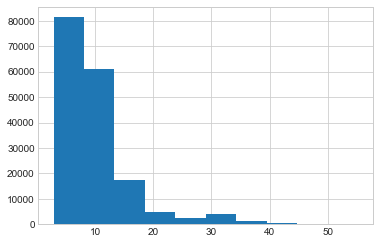

In [326]:
plt.hist(x_val_predictions)

## Feature Importance

Lets see which features contributed to Best models accuracy

In [327]:
feature_importances = full_pipeline_with_bestmodel.named_steps.predictor.feature_importances_
feature_importances

array([0.08670267, 0.09239527, 0.1113706 , 0.16362575, 0.07984236,
       0.11793899, 0.13428697, 0.0491899 , 0.07867464, 0.08597285],
      dtype=float32)

In [328]:
attributes = ['haversine','dropoff_jfk_distance','pickup_longitude','dropoff_longitude','pickup_jfk_distance','pickup_ewr_distance','dropoff_ewr_distance','distance_to_center','dropoff_latitude','pickup_lga_distance']
sortedFeatures = sorted(zip(feature_importances, attributes), reverse=False)

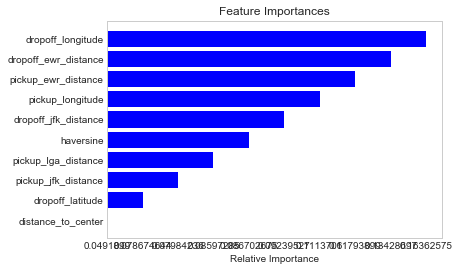

In [329]:
# Plot the feature importances of the forest
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.figure() 
plt.title("Feature importances")
sortedNames = np.array(sortedFeatures)[:, 1]
sortedImportances = np.array(sortedFeatures)[:, 0]

plt.title('Feature Importances')
plt.barh(range(len(sortedNames)), sortedImportances, color='b', align='center')
plt.yticks(range(len(sortedNames)), sortedNames)
plt.xlabel('Relative Importance')
plt.grid()
plt.show()

Above graph shows that distance, pickup_longitude, dropoff_longitude, dropoff_latitude, pickup_latitude, year contributed heavily towards model accuracy. This results are in-line with our select K-best feature selection output.

# Phase2: Use the full Train Data (55M)

In [331]:
train = feather.read_dataframe('data/data.feather')

In [332]:
train = train.drop(['key'], axis=1)

In [333]:
train.shape

(55423856, 7)

In [334]:
print('Original number of rows: %d' % len(train))
train = train.dropna(how='any', axis='rows')
print('No. of rows after dropping missing values: %d' % len(train))

Original number of rows: 55423856
No. of rows after dropping missing values: 55423480


In [335]:
low = .02
high = .98
quant_train = train.quantile([low, high])
print(quant_train)

      fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0.02  3.50        -74.010293         40.595882       -74.011907           
0.98  46.54       -73.137393         40.799847       -73.484463           

      dropoff_latitude  passenger_count  
0.02  40.577163         1.0              
0.98  40.810172         6.0              


In [336]:
num_attribs = ['pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
 'fare_amount', 
    ]

features=['pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude', 
    'passenger_count','fare_amount', 'hour', 'day', 
    'month', 'year', 'haversine', 'distance_to_center', 
    'pickup_jfk_distance', 'dropoff_jfk_distance', 
    'pickup_ewr_distance', 'dropoff_ewr_distance', 
    'pickup_lga_distance', 'dropoff_lga_distance']

dataprep_pipeline = Pipeline([
        ('data_cleaner', DataCleaner(low=0.02,high=0.98)),
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder(features)),
        ('data_cleaner2', DataCleaner2()),
    ])

In [337]:
trainprep = dataprep_pipeline.fit_transform(train)

In [338]:
trainprep.shape

(47917777, 18)

In [339]:
alltrain_y = trainprep['fare_amount']
alltrain_X = trainprep.drop(['fare_amount'], axis=1)

In [340]:
best_model = XGBRegressor(max_depth=3, learning_rate=0.2, n_estimators=100)
#RandomForestRegressor(random_state=42,n_jobs=-1,max_features=4,n_estimators=30) Phase 1 Best Model
full_pipeline_with_bestmodel = Pipeline([
        ('std_scaler', StandardScaler()),
        ('feature selection', TopFeatureSelector(featureScores, 10)),
        ("predictor", best_model)
        ])

In [341]:
%%time
full_pipeline_with_bestmodel.fit(alltrain_X, alltrain_y)

[08:51:06] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
Wall time: 2h 33min 40s


Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature selection', TopFeatureSelector(feature_importances=array([1.09475e+05, 9.15290e+03, 1.09185e+05, 2.84847e+04, 1.13657e+02,
       1.67323e+02, 3.26241e+01, 5.01238e+02, 8.96720e+03, 2.27344e+06,
       4.08945...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

# Final Test Data Prediction 

Moment of Truth !! <p>
We have experimented and trained our model with the best parameters, and validated against val set.<p>
Now we have to see how it works on actual test data of ~10k rows.

In [366]:
# column index
datetime_ix, lon1_ix, lat1_ix, lon2_ix, lat2_ix = 1, 2, 3, 4, 5

num_attribs = ['key','pickup_datetime',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'passenger_count',
    ]

features=['key','pickup_longitude', 'pickup_latitude', 
    'dropoff_longitude', 'dropoff_latitude', 
    'passenger_count', 'hour', 'day', 
    'month', 'year', 'haversine', 'distance_to_center', 
    'pickup_jfk_distance', 'dropoff_jfk_distance', 
    'pickup_ewr_distance', 'dropoff_ewr_distance', 
    'pickup_lga_distance', 'dropoff_lga_distance']

dataprep_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('attribs_adder', CombinedAttributesAdder(features)),
    ])

In [367]:
testclean = dataprep_pipeline.fit_transform(test)

In [368]:
testclean.shape

(9914, 18)

In [369]:
testclean.head()

,key,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,hour,day,month,year,haversine,distance_to_center,pickup_jfk_distance,dropoff_jfk_distance,pickup_ewr_distance,dropoff_ewr_distance,pickup_lga_distance,dropoff_lga_distance
0,2015-01-27 13:08:24,-73.973320,40.763805,-73.981430,40.743835,1,13,1,1,2015,1.443696,3.971578,13.313382,12.820167,11.351101,10.424876,5.351330,6.145537
1,2015-01-27 13:08:24,-73.986862,40.719383,-73.998886,40.739201,1,13,1,1,2015,1.507137,0.945420,12.209269,13.420377,9.699638,9.456560,7.194219,7.112902
2,2011-10-08 11:53:44,-73.982524,40.751260,-73.979654,40.746139,1,11,5,10,2011,0.384421,2.994219,13.160856,12.833635,10.556998,10.566998,6.026075,6.000558
3,2012-12-01 21:12:12,-73.981160,40.767807,-73.990448,40.751635,1,21,5,12,2012,1.218604,4.114308,13.805493,13.514332,11.109241,10.185545,5.717524,6.415908
4,2012-12-01 21:12:12,-73.966046,40.789775,-73.988565,40.744427,1,21,5,12,2012,3.347720,5.791718,14.268234,13.153650,12.555521,10.088736,4.964492,6.478675


In [370]:
testprep = testclean.drop(['key'], axis=1)

In [371]:
testprep.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'hour', 'day', 'month', 'year',
       'haversine', 'distance_to_center', 'pickup_jfk_distance',
       'dropoff_jfk_distance', 'pickup_ewr_distance', 'dropoff_ewr_distance',
       'pickup_lga_distance', 'dropoff_lga_distance'],
      dtype='object')

In [372]:
predictions = full_pipeline_with_bestmodel.predict(testprep)

(array([4401., 2936., 1137.,  495.,  222.,  157.,  173.,  189.,  132.,
          72.]),
 array([ 4.26334   ,  8.25597267, 12.24860535, 16.24123802, 20.2338707 ,
        24.22650337, 28.21913605, 32.21176872, 36.2044014 , 40.19703407,
        44.18966675]),
 <a list of 10 Patch objects>)

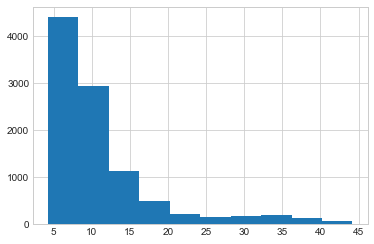

In [373]:
plt.hist(predictions)

## Kaggle Submission

In [376]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('submissionalltrainphase2.csv', index=False)

![title](image/55Mphase2.png)

# Next Steps - Phase 3

In the last phase of the project, we will try to focus on achieving better accuracy for our dataset. We plan to do the following:
- Try to experiment with Support Vector Machines
- Add more hyperparameters to the models
- Run model tuning for more iterations on more data
- Experiment with some other strategies for outlier removal (currently we are using the percentile approach) if possible